## ECBM4070 Project Part 2


### 1. CX circuit model

#### 1a. Generate moving bar
The moving bar moves back and forth laterally, looping until the end of the simulation duration (120s)

In [1]:
%matplotlib inline
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from numpy import *

In [2]:
# Generate moving bar stimulus
def generate_input(bar_width=4, width=48, height=32, steps=120, direction='right and left', speed=1, amplitude=1., dt=1e-3):
    '''Create a Vertical Moving Bar Stimulus.
        
    Parameters
    ----------
    bar_width: int
        Width of the moving bar
    width: int
        width of the whole window
    height: int
        height of the whole window
    steps: int
        number of steps to generated the input
    direction: str
        - 'left': bar moves left from the right edge
        - 'right': bar moves right from the left edge
        - 'left and right': bar moves to right then left in cycles
    speed: int
        speed at which bar is moving
    amplitude: float
        amplitude of the bar
    
    Returns
    -------
    X: np.ndarray of shape (height, width, steps)
        The height and width dimensions are flipped as per convention for images
        Index a frame of the image at time index t as `X[..., t]`
    '''
    assert direction in ['continuous', 'fixed and continuous'], \
        "direction should be 'continuous' or 'fixed and continuous', got {} instead".format(direction)
    X = np.zeros((height,width,steps))
    num_bounces = int(steps*dt/width) # finds number of times the moving bar changes direction
    left = np.zeros((height,width,int(width/dt)))
    right = np.zeros((height, width, int(width/dt)))
    for i in range(width+1):
        x = int(np.floor(width * i * speed / width))
        xmin = int(np.max((0, x-bar_width)))
        if xmin == X.shape[1]:
            # flew off the screen
            break
        #right[:,xmin:xmin+1,int(i/dt):int((i+1)/dt)] = amplitude* np.random.randint(low=1, high=5)   
        #right[:,xmin+1:xmin+2,int(i/dt):int((i+1)/dt)] = amplitude* np.random.randint(low=1, high=5) 
        #right[:,xmin+2:xmin+3,int(i/dt):int((i+1)/dt)] = amplitude* np.random.randint(low=1, high=5) 
        #right[:,xmin+3:xmin+4,int(i/dt):int((i+1)/dt)] = amplitude* np.random.randint(low=1, high=5) 
        right[:,xmin:x,int(i/dt):int((i+1)/dt)] = amplitude
    left=right[...,::-1]

    for b in range(num_bounces):
      if b%2==0:
        X[:,:,int(b*width/dt):int((b+1)*width/dt)] = right
      if b%2==1:  # if moving to the left
        X[:,:,int(b*width/dt):int((b+1)*width/dt)]= left
    
    return X #[24 x 32 x 120]

In [3]:
# Customize stimulus parameters 
dt=1e-3  #1ms 
fs=1/dt
width=48
num_ri=8
duration=96 #120s of simulation
t_range=np.arange(0,duration, dt)
steps=int(duration/dt) # number of steps
bar= generate_input(bar_width=4, width=48, height=32, steps=steps, direction='continuous', speed=1, amplitude=1., dt=dt)  #(32, 48, 12,000) where each step takes 1e-4s
bar=bar*99+1  # convert binary input to 1 and 100 
bar.shape

(32, 48, 96000)

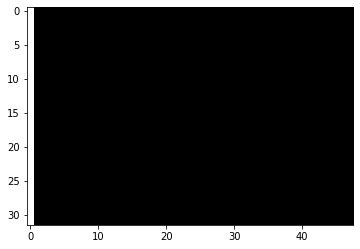

In [4]:
# Visualize 10 frames of the moving bar to show motion
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(bar[0,0,0:2000])):
    frames.append([plt.imshow(bar[:,:,i], cmap=cm.Greys_r, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval = 1000, blit=True, repeat_delay=0)
ani.save('moving_bar.mp4')
from IPython.core.display import Video
Video("moving_bar.mp4")

Text(0.5, 1.0, 'Frame at 20s')

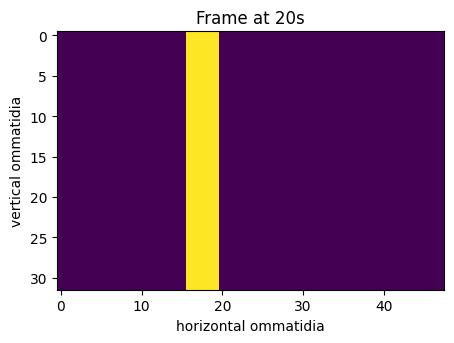

In [5]:
# Plot sample frame
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [5,5]
plt.imshow(bar[:,:,20000])
plt.xlabel('horizontal ommatidia')
plt.ylabel('vertical ommatidia')
plt.title('Frame at 20s')

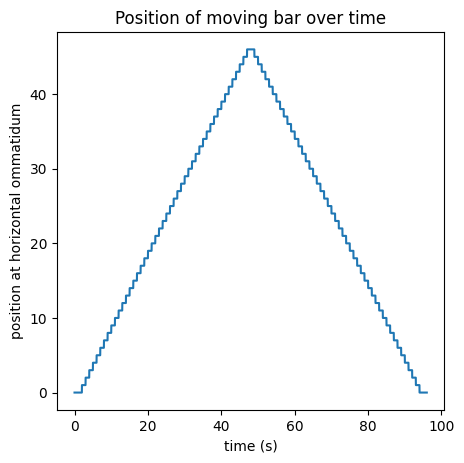

In [6]:
# Plot positon of bar over time
position_over_time=np.zeros(steps,)
for step in range(steps):
  if math.floor(step*dt)==0 or math.floor(step*dt+1)==96:
    continue
  #print(step)
  frame=bar[:,:,step]
  indices=np.where(frame>=100)  # find indices where 100 appear
  #print(step)
  position_over_time[step]=indices[1][-1]  #store the position of last index where 1 appears (edge of the bar)

time_range=np.arange(0,duration, dt, dtype=float)  # time array in seconds (120s)
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [5,5]
plt.plot(time_range,position_over_time)
plt.title('Position of moving bar over time')
plt.xlabel('time (s)')
plt.ylabel('position at horizontal ommatidum')
plt.savefig('position over time.png')

#### 1b. AVDU motion detector

input: ```moving bar stimulus``` \\
output: ```pg_r, pg_l, rg_r, rg_l```

In [7]:
# Build classic HR detector

def delay(X, n=1):
  # implement delay for index n (note n could be negative)
  if n<=0:
      return X    # np.roll
  return np.append(np.zeros((X.shape[0],X.shape[1],n)), X[:,:,0:-n], axis=2) # append zeros to beginning

def HR_Detector_step(frame, tau, taub, dt): # input is frame at a time step (from right or left) size (32,24)
  frame=np.sum(frame,axis=0) #sum over columns of ommatidia
  sum_left=np.zeros(len(frame),) # size (24,1)
  sum_right=np.zeros(len(frame),) # size (24,1)

  # leaky integrator 
  for om in range(len(frame)-1):
    left=frame[om]
    right=frame[om+1]
    left_leak=left+(-left/tau)*dt
    right_leak=right+(-right/tau)*dt
    left_middle=left+(-left/taub)*dt
    right_middle=right+(-right/taub)*dt

    #multiply and sum over eye
    left_mult=left_leak*right_middle
    right_mult=right_leak*left_middle
    sum_left=sum_left+left_mult
    sum_right=sum_right+right_mult

  sum_left=np.sum(sum_left) # sum over (32,1) to get (1,1)
  sum_right=np.sum(sum_right) # sum over (32,1) to get (1,1)
  output=(sum_left-sum_right)*1e10

  return sum_left, sum_right, output

In [8]:
# Build more complex AVDU detector
def AVDU_detector_step(frame, dt, tau_1=5e-3, tau_2=15e-3, tau_b=3e-3, tau_s=10e-3):  # input [32 x 48 x 1], taus are time constants in seconds

  # Find outputs of two HR detectors
  #left_frame=X[:,0:24]
  #right_frame=X[:,25:48]
  HR_left_l, HR_left_r, HR_left_o = HR_Detector_step(frame, tau_1, tau_b,dt)
  HR_right_l, HR_right_r, HR_right_o = HR_Detector_step(frame, tau_2, tau_b,dt)

  # perform division
  rg_div=HR_left_l/(HR_right_l+1)
  pg_div=HR_left_r/(HR_right_r+1)

  # leaky integrator with tau_s
  left_leak=HR_left_o+(-HR_left_o/tau_s)*dt
  right_leak=HR_right_o+(-HR_right_o/tau_s)*dt

  # addition and subtraction before final delay
  left_last=rg_div-left_leak
  right_last=pg_div+right_leak

  # final leak
  rg_out=left_last+(-left_last/tau_s)*dt
  pg_out=right_last+(-right_last/tau_s)*dt

  return rg_out, pg_out  #(1,1) multiply by constant during tuning


In [9]:
# TODO: Run AVDU Detector on the moving bar with delay and visualize Input (X) and Output (Motion) for 5 frames
pg_l=np.zeros(steps,) # initialize detector outputs 
rg_l=np.zeros(steps,)
pg_r=np.zeros(steps,)
rg_r=np.zeros(steps,)

left_l=np.zeros(steps,)
left_r=np.zeros(steps,)
left_o=np.zeros(steps,)
right_l=np.zeros(steps,)
right_r=np.zeros(steps,)
right_o=np.zeros(steps,)

tau_1=5e-3
tau_2=15e-3
tau_b=3e-3
tau_s=10e-3

for t in range(steps):
  left_frame=bar[:,0:24,t]
  right_frame=bar[:,24:48,t]
  frame=bar[:,:,t]

  rg_l[t], pg_l[t]=AVDU_detector_step(left_frame, dt)
  rg_r[t], pg_r[t]=AVDU_detector_step(right_frame, dt)

print(pg_l, pg_r, rg_l, rg_r)

[0.77142638 0.77142638 0.77142638 ... 0.77142638 0.77142638 0.77142638] [0.77142638 0.77142638 0.77142638 ... 0.77142638 0.77142638 0.77142638] [0.77142638 0.77142638 0.77142638 ... 0.77142638 0.77142638 0.77142638] [0.77142638 0.77142638 0.77142638 ... 0.77142638 0.77142638 0.77142638]


[Text(0.5, 0, 'time (s)'),
 Text(0, 0.5, 'detector output'),
 Text(0.5, 1.0, 'Regressive outputs of the right eye')]

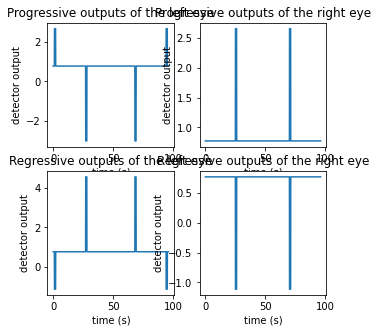

<Figure size 1200x1200 with 0 Axes>

In [10]:
# Plot AVDU outputs over time (rg_l, pg_l, rg_r, pg_r)

fig, axs = plt.subplots(2,2)
fig=plt.figure(figsize=(12,12), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [12, 12]
fig.suptitle('Progressive (pg) and regressive (rg) AVDU detector outputs of left and right eye')
axs[0,0].plot(t_range, pg_l)
axs[0,0].set(xlabel='time (s)', ylabel='detector output',
       title='Progressive outputs of the left eye')

axs[0,1].plot(t_range, pg_r)
axs[0,1].set(xlabel='time (s)', ylabel='detector output',
       title='Progressive outputs of the right eye')

axs[1,0].plot(t_range, rg_l)
axs[1,0].set(xlabel='time (s)', ylabel='detector output',
       title='Regressive outputs of the left eye')

axs[1,1].plot(t_range, rg_r)
axs[1,1].set(xlabel='time (s)', ylabel='detector output',
       title='Regressive outputs of the right eye')

#### 1c. Ring attractor network

input: ```pg_r, pg_l, rg_r, rg_l``` \\
output: ```r(t)```

In [11]:
# Build functions for dc, da, a, c
def da_step(da_prev, pg_l,rg_r, dt, t_y=1e-3): # da_prev of size (16,), t_y is leaky integrator constant of 1e-3
    '''
    anticlockwise driver signal function
    '''
    dda = (-da_prev+pg_l+rg_r) / t_y
    
    da = da_prev + dt*dda
    #da = da / np.max(da)
    return da #output size (1,) for each time step


def a_step(r_i,da):  # r_i of size (16,)
    '''
    anticlockwise rotation ciruit function
    '''
    #da = da_step(da_prev,pg_l,rg_r,dt)
    a_i = da*r_i # size(16,)
    a_i = np.maximum(0.*a_i,a_i) # cant be negative
    where_are_NaNs = isnan(a_i)
    a_i[where_are_NaNs] = 0
    #a_i = a_i / np.max(a_i)
    a_i=np.interp(a_i,(a_i.min(), a_i.max()), (-5, 5))
    return a_i  #output of size [16,] for each time step

def dc_step(dc_prev, pg_r,rg_l, dt, t_y=1e-3): #dc_prev of size (16,)
    '''
    clockwise driver signal function
    '''
    ddc = (-dc_prev+pg_r+rg_l) / t_y

    dc = dc_prev + dt*ddc
    #dc = dc / np.max(dc)
    return dc  #size (1,) for each time step

def c_step(r_i,dc): # r_i of size (16,)
    '''
    clockwise rotation ciruit function
    '''
    #dc = dc_step(dc_prev,pg_r,rg_l, dt)
    c_i = dc*r_i  # size(8,)
    c_i = np.maximum(0.*c_i,c_i) # cant be negative
    where_are_NaNs = isnan(c_i)
    c_i[where_are_NaNs] = 0
    #c_i = c_i / np.max(c_i)
    c_i=np.interp(c_i,(c_i.min(), c_i.max()), (-5, 5))
    return c_i  #output of size [8,] for each time step


In [12]:
# Build functions for Left and Right receptive fields
def RF_step(frame, bin_width=3): #input frame of size (32, 48) for left/right
    '''
    left receptive field function
    '''
    frame=np.sum(frame, axis=0) # size (48,)
    RF_out=np.zeros(int(len(frame)/bin_width),)

    for bin in range(int(len(frame)/bin_width)): # range(16)
      RF_out[bin]=np.sum(frame[bin*bin_width:bin*bin_width+bin_width])
    #RF_out=np.interp(RF_out,(RF_out.min(), RF_out.max()), (-1, 1))
    return RF_out  # output size (16,) for left or right each at each t step


def p_step(p_prev, RF_l, RF_r, max_ri=16, t_y=1e-4, dt=1e-3): #RF in size (8,) each, p_prev of size (16,)
    '''
    positional landmark neuron input function
    '''
    dp=np.zeros(max_ri,)
    for i in range(max_ri):
        if i < max_ri/2: # maximum value of i = 16
            dp[i] = (-p_prev[i] + RF_l[i] - 10*(np.sum(p_prev)-p_prev[i])) / t_y
        if i >= max_ri/2:
            dp[i] = (-p_prev[i] + RF_r[int(max_ri/2)-i] - 10*(np.sum(p_prev)-p_prev[i])) / t_y 
    
    p=p_prev+dp*dt
    p = np.maximum(0.*p,p) # cant be negative

    return p #output of size (16,) for left plus right at each t step

In [13]:
# Build helper functions for excitatory and inhibitory connectivity
def E_step(r_i, w1=0.6, w2=0.35, w3=0.225, max_ri=16):  #input r_i of size(16,) at each t step
  '''
  excitatory connectivity function
  '''
  E=np.zeros(max_ri,) 
  for i in range(max_ri):
    E[i] = w1*r_i[i] + w2*( ( r_i[(i+1)%np.max(i)] ) +  ( r_i[(i-1)%np.max(i)] ) ) 
    + w3*( ( r_i[(i+2)%np.max(i)] ) + ( r_i[(i-2)%np.max(i)] ) )  # r_2, weight using conn between r2 and r1, and r2 and r3
  E= np.maximum(0.*E,E) # cant be negative
  #E = E / np.max(E)
  where_are_NaNs = isnan(E)
  E[where_are_NaNs] = 0
  #E=np.interp(E,(E.min(), E.max()), (-1, 1))
  return E  # output of size (16,) for each time step

def I_step(r_i, w=-0.1, max_ri=16): #input r_i of size(16,)
  '''
  inhibitory connectivity function
  '''
  I = np.zeros(max_ri,)
  for i in range(max_ri):
    I[i] = w*np.sum(r_i)
  I = np.minimum(0.*I,I) # cant be negative
  where_are_NaNs = isnan(I)
  I[where_are_NaNs] = 0
  #I = I / np.max(I)
  #I=np.interp(I,(I.min(), I.max()), (-1, 1))
  return I #output of size (16,) for each time step

In [14]:
# Build function for ring connectivity
def r_step(r_prev, E, I, p, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)

    dr = ( -r_prev + E + I + w_p*p + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

### 2. Replication of Experiment 1 from Cope et al. (2017)

In [15]:
# Initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

# Run helper functions for r(t) main function
for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  RF[:,t]=RF_step(bar[:,:,t])
  p[:,t+1]=p_step(p[:,t], RF[0:num_ri,t], RF[num_ri:num_ri*2,t])
 # print('RF', RF[:,t], 'p', p[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], p[:,t+1], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':


### 3. Experiment 1 Plots

[Text(0.5, 0, 'time (s)'),
 Text(0, 0.5, 'da'),
 Text(0.5, 1.0, 'Anticlockwise driver signal over time')]

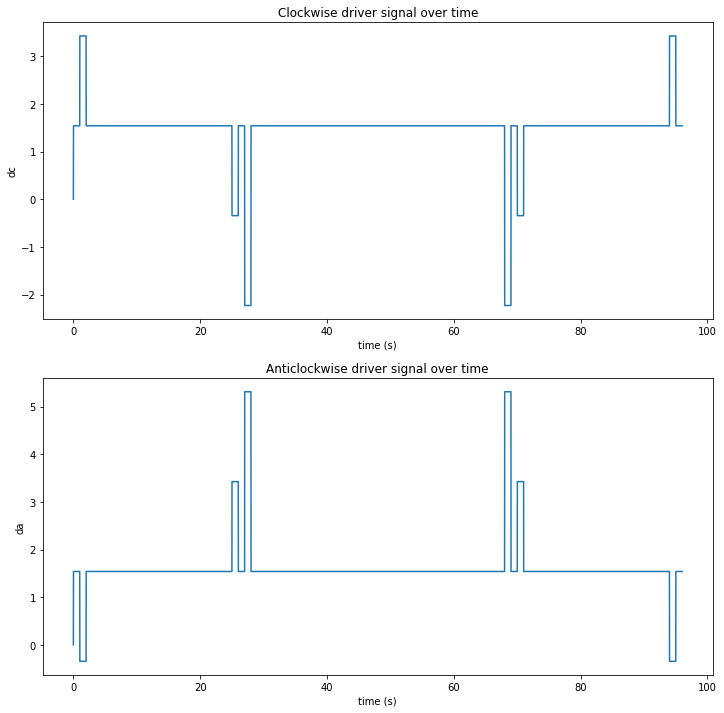

<Figure size 800x800 with 0 Axes>

In [16]:
# Plot dc, da over time 

fig, axs = plt.subplots(2)
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [12, 12]
fig.suptitle('dc, da, a, c of ring attractor network over timee')
axs[0].plot(t_range, dc)
axs[0].set(xlabel='time (s)', ylabel='dc',
       title='Clockwise driver signal over time')

axs[1].plot(t_range, da)
axs[1].set(xlabel='time (s)', ylabel='da',
       title='Anticlockwise driver signal over time')


Text(0.5, 1.0, 'Anticlockwise signal over time')

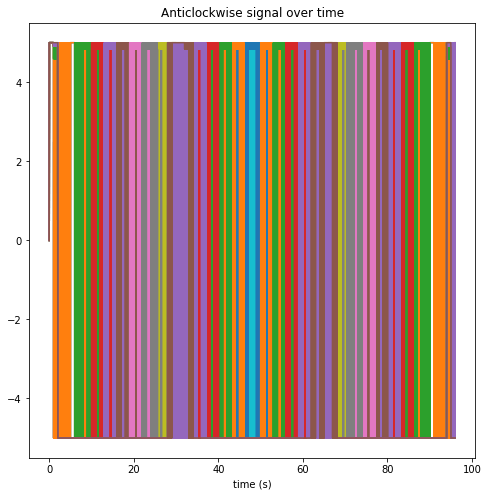

In [17]:
# Plot a over time
plt.rcParams['figure.figsize'] = [8, 8]

for i in range(num_ri*2):
  plt.plot(t_range, a[i,:])
plt.xlabel('time (s)')
# plt.ylabel('a signal')
plt.title('Anticlockwise signal over time')


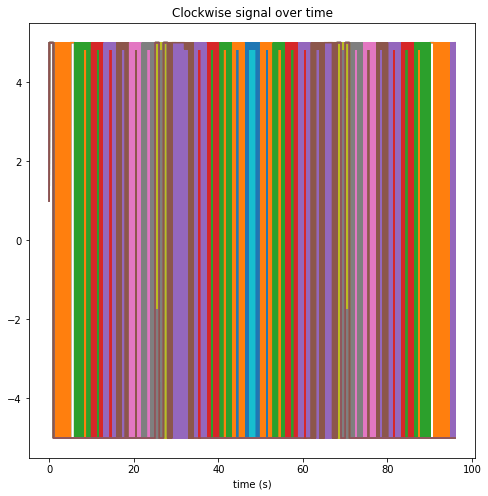

In [18]:
# Plot c over time
plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, c[i,:])
  plt.xlabel('time (s)')
  # plt.ylabel('c signal')
  plt.title('Clockwise signal over time')

Text(0.5, 1.0, 'Receptive field over time')

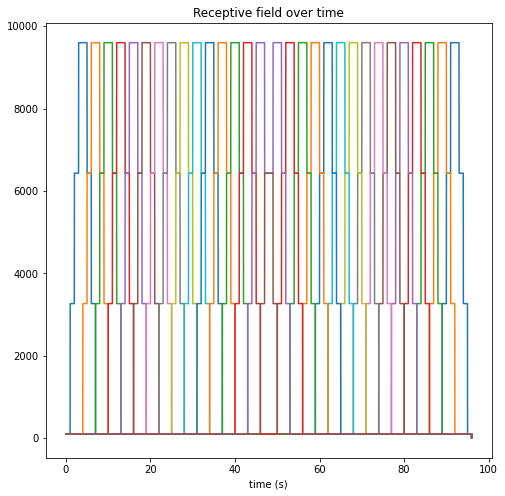

In [19]:
# Plot RF 

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, RF[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Receptive field over time')

Text(0.5, 1.0, 'Positional input over time')

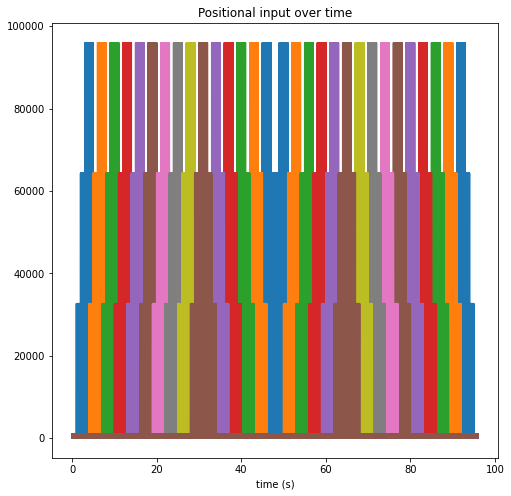

In [20]:
# Plot p_i output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, p[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Positional input over time')

Text(0.5, 1.0, 'Excitatory signal over time')

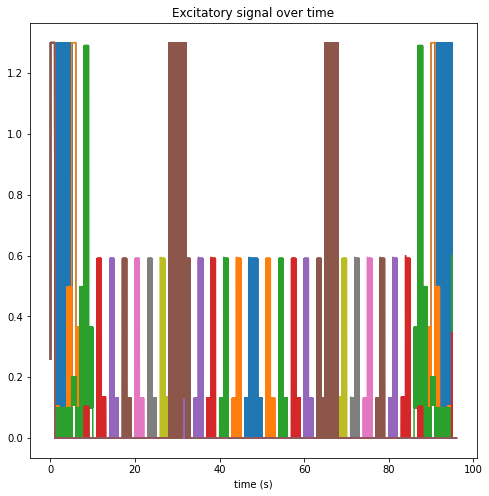

In [21]:
# Plot excitatory output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, E[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Excitatory signal over time')

Text(0.5, 1.0, 'Inhibitory signal over time')

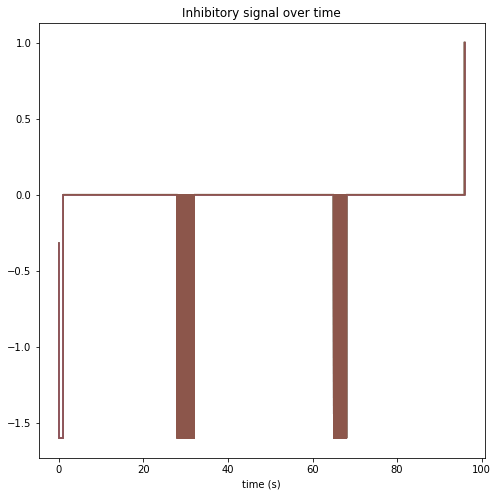

In [22]:
# Plot inhibitory output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, I[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Inhibitory signal over time')

Text(0.5, 1.0, 'Ring neuron output over time')

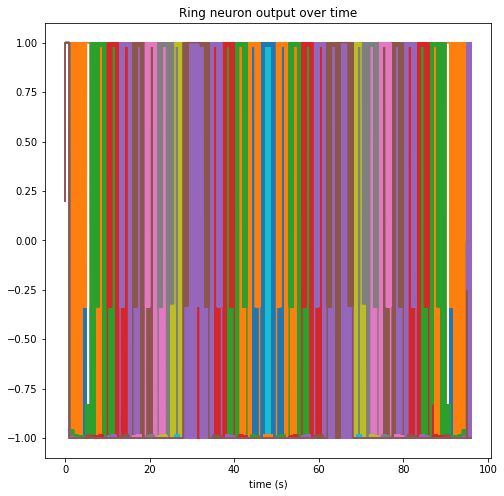

In [23]:
# Plot ring output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Text(0.5, 1.0, 'Ring neuron output with motion + position input')

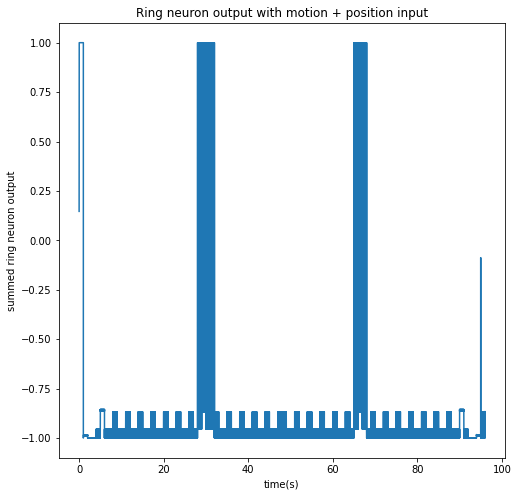

In [24]:
# Plot comparable output
output=np.sum(r, axis=0)
output=np.interp(output, (output.min(), output.max()), (-1, 1))
plt.plot(t_range, output)
plt.xlabel('time(s)')
plt.ylabel('summed ring neuron output')
plt.title('Ring neuron output with motion + position input')

3a. Plot position-only input

In [25]:
# Build function for ring neuron activity 
def r_step(r_prev, p, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)
    dr = ( -r_prev + w_p*p + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

In [26]:
# Initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':


Text(0.5, 1.0, 'Ring neuron output over time')

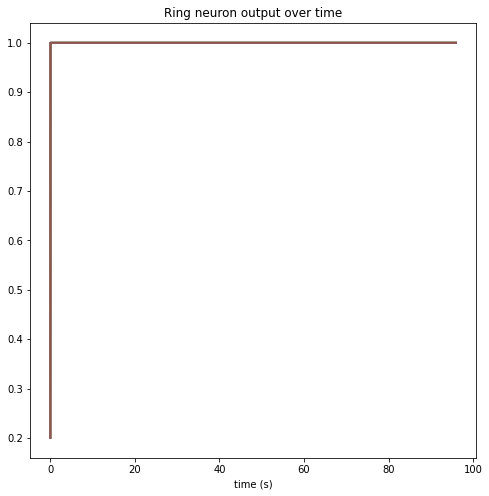

In [27]:
# Plot ring output
plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Text(0.5, 1.0, 'Ring neuron output with position input only')

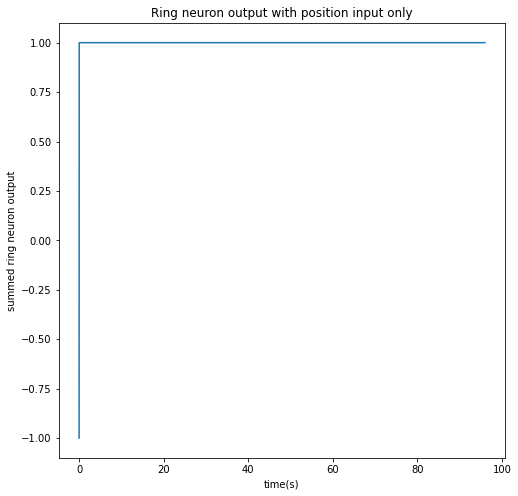

In [28]:
# Plot comparable output
output=np.sum(r, axis=0)
output=np.interp(output, (output.min(), output.max()), (-1, 1))
plt.plot(t_range, output)
plt.xlabel('time(s)')
plt.ylabel('summed ring neuron output')
plt.title('Ring neuron output with position input only')

3b. Motion-only input

In [29]:
# Build function for ring neuron activity
def r_step(r_prev, E, I, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)

    dr = ( -r_prev + E + I + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

In [30]:
# Initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':


Text(0.5, 1.0, 'Ring neuron output over time')

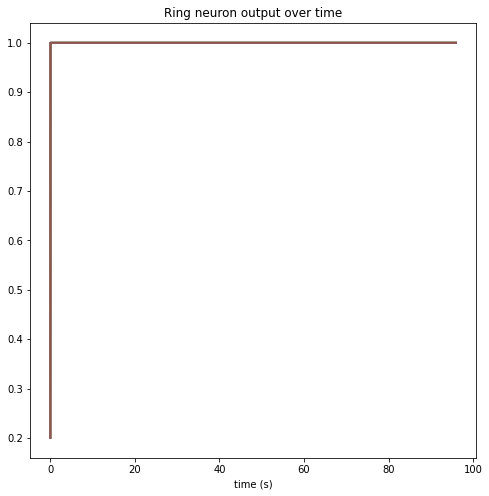

In [31]:
# Plot ring output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Text(0.5, 1.0, 'Ring neuron output with motion input only')

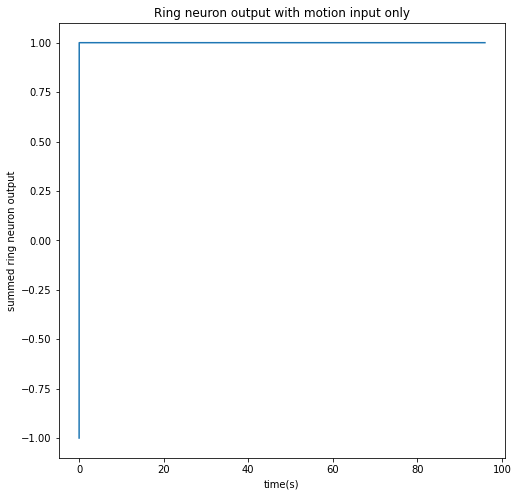

In [32]:
# Plot comparable output
#plt.plot(t_range, np.sum(r, axis=0))
output=np.sum(r, axis=0)
output=np.interp(output, (output.min(), output.max()), (-1, 1))
plt.plot(t_range, output)
plt.xlabel('time(s)')
plt.ylabel('summed ring neuron output')
plt.title('Ring neuron output with motion input only')

### 4. Update model with connectivity weights

In [33]:
# Connectivities for L1-L8,R1-R8 obtained from NeuroNLP. 
# Each neuron has ~16 connections, these are summed into the list below using excel
conn=np.array([[72, 21,2,1,0,0,3,7,36,0,0,0,0,0,3,81 ], [8, 41,2,2,0,2,0,1,1,0,0,0,0,0,51,47], [2,4,98,3,1,0,5,0,0,0,0,0,0,32,53,0], [0,1,5,31,5,1,0,2,0,0,0,0,25,49,0,0], [2,0,2,4,32,5,0,1,0,0,0,57,13,0,0,0], [ 0,1,0,4,8,54,6,4,0,0,37,0,0,0,0,0], [ 2,1,5,0,2,7,40,2,0,11,9,0,0,0,0,0], [ 0,0,0,1,1,3,16,74,0,0,0,0,0,0,0,0] , [ 0,0,0,1,1,3,14, 74, 6, 51, 3, 0,0,0,0,0], [63, 0, 1, 0,0,0,1, 43, 58, 2, 1, 0,0,0,0,8 ], [ 0,0,0,0,0,0,61, 50, 7, 31,13,0,0,0,0,0], [0,0,0,0,3,72,17,4,0,6,47,13,0,0,0,0 ], [ 0,0,0,4,15, 83,3,1,0,1,9,19,62,0,0,0,0], [0,0,2,11,57,2,0,0,0,0,0,18,47,7,0,0 ], [0,2,70,19, 0,0,0,0,0,0,0,0,2,69,16,1, ], [ 2,54,58, 3, 0,0,0,0,1,0,0,0,0,7,100,14 ], [ 31, 17, 1, 0,0,0,0,0,6,0,0,0,0,0,4,50] ])
# conn has size (16,16) in order of L1, 2, ...8, R1, 2, 3....8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
# Build function for mapping connectivity weights
def ConnWeight(r,conn=conn,beta=0,alpha=1,): #input Ri
  '''
  Transform normalized connectivites from NeuroNLP to weights for the CX functions
  '''
  norm_conn=[]
  for c in conn:
    for w in c:
      w=(beta+(w/alpha)) # apply transform to each connectivity 
    norm_conn.append(c/np.sum(c)) # normalize the matrix

  # Output one weight from connectivity between Ri & Ri-1 and Ri & Ri+1
  # weight is derived by adding adjacent 
  if r < 15:
    w_conn = norm_conn[r][r-1] + norm_conn[r][r+1]
  else:
    w_conn = norm_conn[r][r-1] + norm_conn[r][0] # wrap to L1 when r == R8

  return w_conn #output (1,) weight derived from conn between Ri & Ri-1 and Ri & Ri+1

In [35]:
# (Re-) Build functions for dc, da, a, c
def da_step(da_prev, pg_l,rg_r, dt, t_y=1e-3): # da_prev of size (16,), t_y is leaky integrator constant of 1e-3
    '''
    anticlockwise driver signal function
    '''
    dda = (-da_prev+pg_l+rg_r) / t_y

    da = da_prev + dt*dda

    #da = da / np.max(da)

    da=np.interp(da, (da.min(), da.max()), (-1, 1))

    return da #da size (1,) for each time step


def a_step(r_i,da):  # r_i of size (16,)
    '''
    anticlockwise rotation ciruit function
    '''
    #da = da_step(da_prev,pg_l,rg_r,dt)
    a_i = da*r_i # size(16,)
    a_i = np.maximum(0.*a_i,a_i) # cant be negative
    where_are_NaNs = isnan(a_i)
    a[where_are_NaNs] = 0

    for r in range(16):
      a_i[r] = a_i[r]*ConnWeight(r)
    #a_i = a_i / np.max(a_i)
    a_i=np.interp(a_i, (a_i.min(), a_i.max()), (-1, 1))
    return a_i  #output of size [16,] for each time step

def dc_step(dc_prev, pg_r,rg_l, dt, t_y=1e-3): #dc_prev of size (16,)
    '''
    clockwise driver signal function
    '''
    ddc = (-dc_prev+pg_r+rg_l) / t_y

    dc = dc_prev + dt*ddc
    #dc = dc / np.max(dc)
    dc=np.interp(dc, (dc.min(), dc.max()), (-1, 1))
    return dc  #size (1,) for each time step

def c_step(r_i,dc): # r_i of size (16,)
    '''
    clockwise rotation ciruit function
    '''
    #dc = dc_step(dc_prev,pg_r,rg_l, dt)
    c_i = dc*r_i  # size(8,)
    c_i = np.maximum(0.*c_i,c_i) # cant be negative
    where_are_NaNs = isnan(c_i)
    c_i[where_are_NaNs] = 0

    for r in range(16):
      c_i[r] = c_i[r]*ConnWeight(r)

    #c_i = c_i / np.max(c_i)

    c_i=np.interp(c_i, (c_i.min(), c_i.max()), (-1, 1))
    return c_i  #output of size [8,] for each time step


In [36]:
def RF_step(frame, bin_width=3): #input frame of size (32, 48) for left/right
    '''
    left receptive field function
    '''
    frame=np.sum(frame, axis=0) # size (48,)
    RF_out=np.zeros(int(len(frame)/bin_width),)

    for bin in range(int(len(frame)/bin_width)): # range(16)
      RF_out[bin]=np.sum(frame[bin*bin_width:bin*bin_width+bin_width])
    RF_out=np.interp(RF_out, (RF_out.min(), RF_out.max()), (-1, 1))
    return RF_out  # output size (16,) for left or right each at each t step


def p_step(p_prev, RF_l, RF_r, max_ri=16, t_y=1e-4, dt=1e-3): #RF in size (8,) each, p_prev of size (16,)
    '''
    positional landmark neuron input function
    '''
    dp=np.zeros(max_ri,)
    for i in range(max_ri):
        if i < max_ri/2: # maximum value of i = 16
            dp[i] = (-p_prev[i] + RF_l[i] - 10*(np.sum(p_prev)-p_prev[i])) / t_y
        if i >= max_ri/2:
            dp[i] = (-p_prev[i] + RF_r[int(max_ri/2)-i] - 10*(np.sum(p_prev)-p_prev[i])) / t_y 
    
    p=p_prev+dp*dt
    p = np.maximum(0.*p,p) # cant be negative
    p = p / np.max(p)
    p=np.interp(p, (p.min(), p.max()), (-1, 1))
    return p #output of size (16,) for left plus right at each t step

In [37]:
# Define helper functions
def E_step(r_i, w1=0.6, w2=0.35, w3=0.225, max_ri=16):  #input r_i of size(16,) at each t step
  '''
  excitatory connectivity function
  '''
  E=np.zeros(max_ri,) 
  for i in range(max_ri):
    E[i] = w1*r_i[i] + w2*( ( r_i[(i+1)%np.max(i)] ) +  ( r_i[(i-1)%np.max(i)] ) ) 
    + w3*( ( r_i[(i+2)%np.max(i)] ) + ( r_i[(i-2)%np.max(i)] ) )  # r_2, weight using conn between r2 and r1, and r2 and r3
  E= np.maximum(0.*E,E) # cant be negative
  #E = E / np.max(E)
  where_are_NaNs = isnan(E)
  E[where_are_NaNs] = 0

  for r in range(16):
    E[r] = E[r]*ConnWeight(r)

  E=np.interp(E, (E.min(), E.max()), (-1, 1))
  return E  # output of size (16,) for each time step

def I_step(r_i, w=-0.1, max_ri=16): #input r_i of size(16,)
  '''
  inhibitory connectivity function
  '''
  I = np.zeros(max_ri,)
  for i in range(max_ri):
    I[i] = w*np.sum(r_i)
  I = np.minimum(0.*I,I) # cant be negative
  where_are_NaNs = isnan(I)
  I[where_are_NaNs] = 0
  #I = I / np.max(I)

  for r in range(16):
    I[r] = I[r]*ConnWeight(r)
  I=np.interp(I, (I.min(), I.max()), (-1, 1))
  return I #output of size (16,) for each time step

In [38]:
def r_step(r_prev, E, I, p, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)

    for r in range(16):
      r_prev[r] = r_prev[r]*ConnWeight(r)

    dr = ( -r_prev + E + I + w_p*p + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

### 5. Rerun CX Model with updated connectivity weights

In [39]:
# Replication of Experiment 1 with updated connectivity weights using GPU

#initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  RF[:,t]=RF_step(bar[:,:,t])
  p[:,t+1]=p_step(p[:,t], RF[0:num_ri,t], RF[num_ri:num_ri*2,t])
# print('RF', RF[:,t], 'p', p[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], p[:,t+1], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


### 6. Plots with updated connectivity weights

[Text(0.5, 0, 'time (s)'),
 Text(0, 0.5, 'da'),
 Text(0.5, 1.0, 'Anticlockwise driver signal over time')]

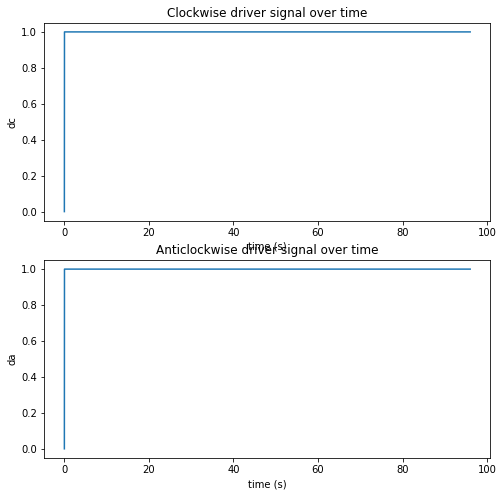

<Figure size 800x800 with 0 Axes>

In [40]:
# Updated plots with connectivity
# plot dc, da over time 

fig, axs = plt.subplots(2)
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [12, 12]
fig.suptitle('dc, da, a, c of ring attractor network over time')
axs[0].plot(t_range, dc)
axs[0].set(xlabel='time (s)', ylabel='dc',
       title='Clockwise driver signal over time')

axs[1].plot(t_range, da)
axs[1].set(xlabel='time (s)', ylabel='da',
       title='Anticlockwise driver signal over time')


Text(0.5, 1.0, 'Anticlockwise signal over time')

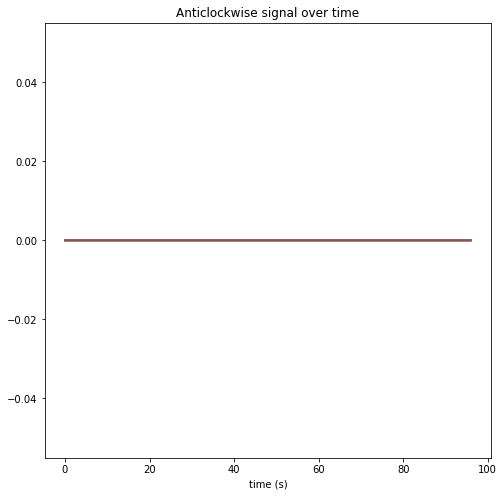

In [41]:
# Plot a over time
plt.rcParams['figure.figsize'] = [8, 8]

for i in range(num_ri*2):
  plt.plot(t_range, a[i,:])
plt.xlabel('time (s)')
#plt.ylabel('a signal')
plt.title('Anticlockwise signal over time')

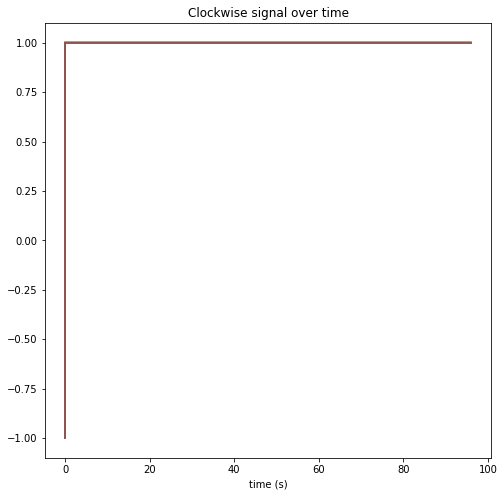

In [42]:
# Plot c over time
plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, c[i,:])
  plt.xlabel('time (s)')
  #plt.ylabel('c signal')
  plt.title('Clockwise signal over time')

Text(0.5, 1.0, 'Receptive field over time')

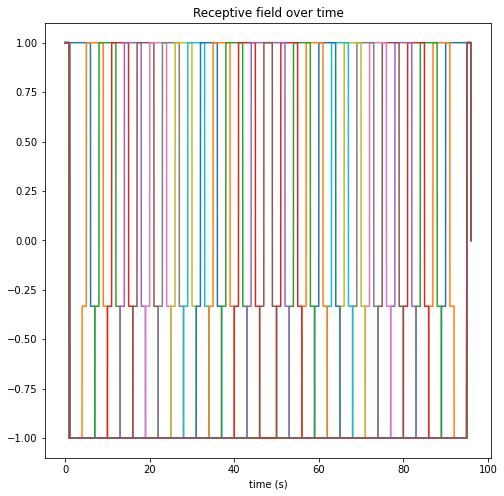

In [43]:
# Plot RF 

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, RF[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Receptive field over time')

Text(0.5, 1.0, 'Excitatory signal over time')

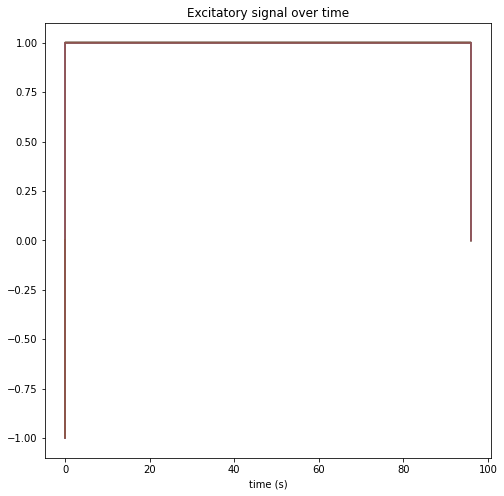

In [44]:
# Plot excitatory output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, E[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Excitatory signal over time')

Text(0.5, 1.0, 'Inhibitory signal over time')

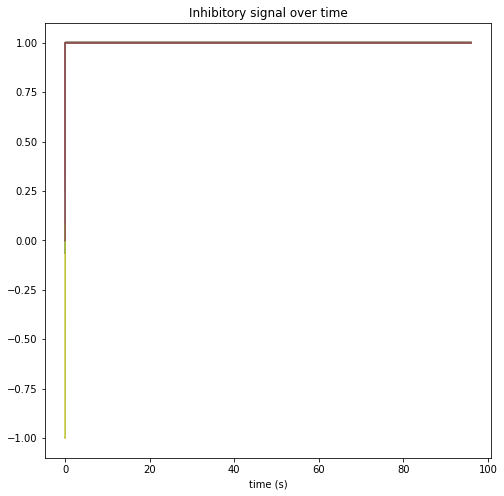

In [45]:
# Plot inhibitory output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, I[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Inhibitory signal over time')

Text(0.5, 1.0, 'Ring neuron output over time')

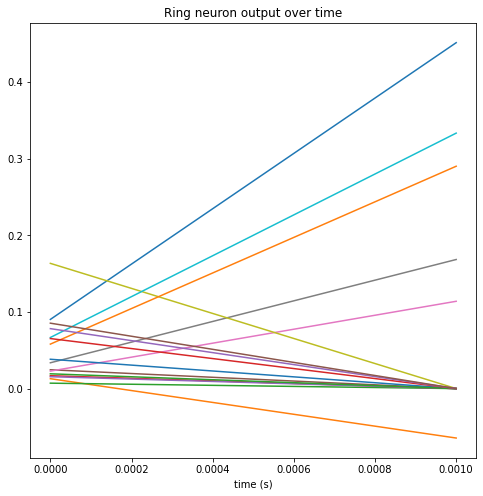

In [46]:
# Plot ring output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Position-only input

In [47]:
def r_step(r_prev, p, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)

    for r in range(16):
      r_prev[r] = r_prev[r]*ConnWeight(r)

    dr = ( -r_prev + w_p*p + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

In [48]:
# Initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  RF[:,t]=RF_step(bar[:,:,t])
  p[:,t+1]=p_step(p[:,t], RF[0:num_ri,t], RF[num_ri:num_ri*2,t])
 # print('RF', RF[:,t], 'p', p[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], p[:,t+1], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Ring neuron output over time')

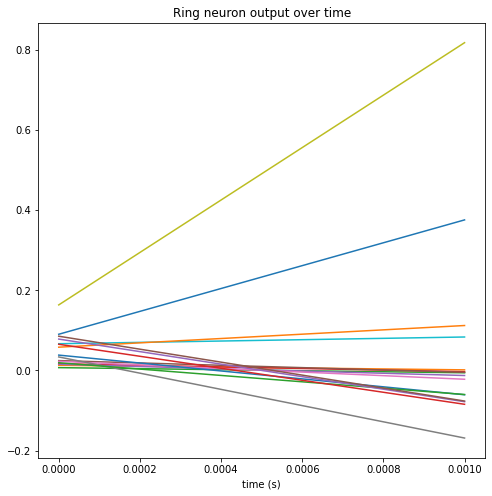

In [49]:
plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Text(0.5, 1.0, 'Ring neuron output with motion + position input')

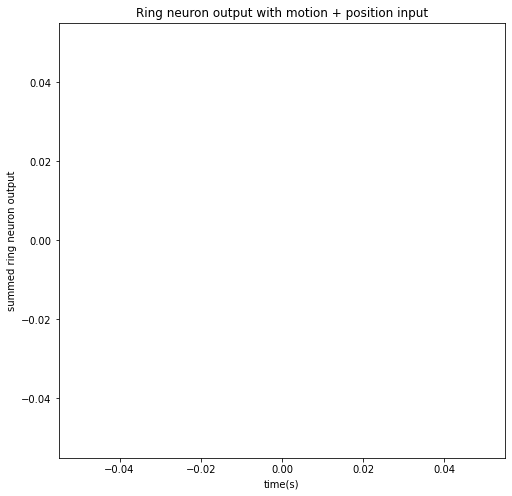

In [50]:
#plt.plot(t_range, np.sum(r, axis=0))
output=np.sum(r, axis=0)
output=np.interp(output, (output.min(), output.max()), (-1, 1))
plt.plot(t_range, output)
plt.xlabel('time(s)')
plt.ylabel('summed ring neuron output')
plt.title('Ring neuron output with motion + position input')

Motion-only input

In [51]:
def r_step(r_prev, E, I, a, c, dt, w_p=0.02, t_r=1e-3, max_ri=16):
    '''
    ring neuron activity function
    '''
    r=np.zeros(max_ri,)

    #shift c and a to get c[i-1] and a[i+1]
    c=np.concatenate((c[-1],c[:-1]),axis=None)
    a=np.concatenate((a[1:],a[0]), axis=None)

    for r in range(16):
      r_prev[r] = r_prev[r]*ConnWeight(r)

    dr = ( -r_prev + E + I + c + a ) / t_r  #(16,)
    r = r_prev + dr*dt
    r = np.maximum(0.*r,r) # cant be negative
    #r = r / np.max(r)
    r=np.interp(r, (r.min(), r.max()), (-1, 1))
    return r  #output size of (16,) for each time step

In [52]:
# Initialize outputs
dc=np.zeros(steps,)
da=np.zeros(steps,)
c=np.ones((num_ri*2,steps)) #size (16,t_steps)
a=np.zeros((num_ri*2, steps))
E=np.zeros((num_ri*2, steps))
I=np.ones((num_ri*2, steps))
RF=np.zeros((num_ri*2, steps))
p=np.zeros((num_ri*2, steps))
r=np.ones((num_ri*2, steps))*0.2

for t in range(steps-1): #initial value for a and c are 0
  dc[t+1]=dc_step(dc[t], pg_l[t], rg_r[t], dt)
  da[t+1]=da_step(da[t], pg_r[t], rg_l[t], dt)
  #print('dc', dc[t+1], 'da', da[t+1])

  c[:,t+1]=c_step(r[:,t], dc[t])
  a[:,t+1]=a_step(r[:,t], da[t])
  #print('c', c[:,t+1], 'a', a[:,t+1])

  RF[:,t]=RF_step(bar[:,:,t])
  p[:,t+1]=p_step(p[:,t], RF[0:num_ri,t], RF[num_ri:num_ri*2,t])
 # print('RF', RF[:,t], 'p', p[:,t+1])

  E[:,t]=E_step(r[:,t])
  I[:,t]=I_step(r[:,t])
  #print('E', E[:,t], 'I', I[:,t])

  r[:,t+1]=r_step(r[:,t], E[:,t], I[:,t], p[:,t+1], a[:,t+1], c[:,t+1], dt)
  #print('r', r[:,t+1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Ring neuron output over time')

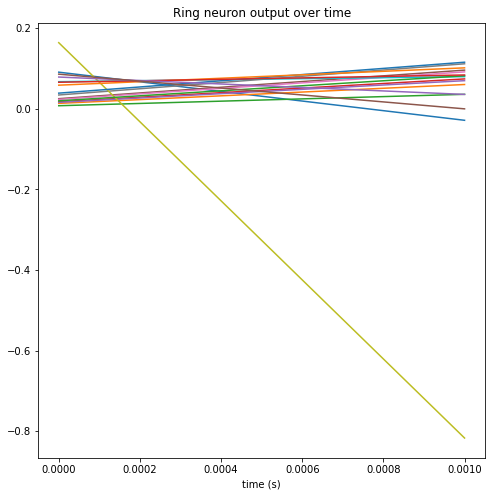

In [53]:
# Plot ring output

plt.rcParams['figure.figsize'] = [8, 8]
for i in range(num_ri*2):
  plt.plot(t_range, r[i,:])
plt.xlabel('time (s)')
#plt.ylabel('RF')
plt.title('Ring neuron output over time')

Text(0.5, 1.0, 'Ring neuron output with motion + position input')

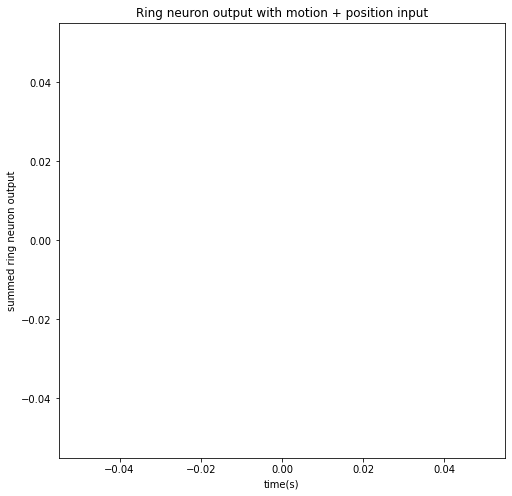

In [54]:
#plt.plot(t_range, np.sum(r, axis=0))
output=np.sum(r, axis=0)
output=np.interp(output, (output.min(), output.max()), (-1, 1))
plt.plot(t_range, output)
plt.xlabel('time(s)')
plt.ylabel('summed ring neuron output')
plt.title('Ring neuron output with motion + position input')

In [55]:
conn=np.array([[72, 21,2,1,0,0,3,7,36,0,0,0,0,0,3,81 ], [8, 41,2,2,0,2,0,1,1,0,0,0,0,0,51,47], [2,4,98,3,1,0,5,0,0,0,0,0,0,32,53,0], [0,1,5,31,5,1,0,2,0,0,0,0,25,49,0,0], [2,0,2,4,32,5,0,1,0,0,0,57,13,0,0,0], [ 0,1,0,4,8,54,6,4,0,0,37,0,0,0,0,0], [ 2,1,5,0,2,7,40,2,0,11,9,0,0,0,0,0], [ 0,0,0,1,1,3,16,74,0,0,0,0,0,0,0,0] , [ 0,0,0,1,1,3,14, 74, 6, 51, 3, 0,0,0,0,0], [63, 0, 1, 0,0,0,1, 43, 58, 2, 1, 0,0,0,0,8 ], [ 0,0,0,0,0,0,61, 50, 7, 31,13,0,0,0,0,0], [0,0,0,0,3,72,17,4,0,6,47,13,0,0,0,0 ], [ 0,0,0,4,15, 83,3,1,0,1,9,19,62,0,0,0], [0,0,2,11,57,2,0,0,0,0,0,18,47,7,0,0 ], [0,2,70,19, 0,0,0,0,0,0,0,0,2,69,16,1, ], [ 2,54,58, 3, 0,0,0,0,1,0,0,0,0,7,100,14 ] ])
conn.shape

(16, 16)

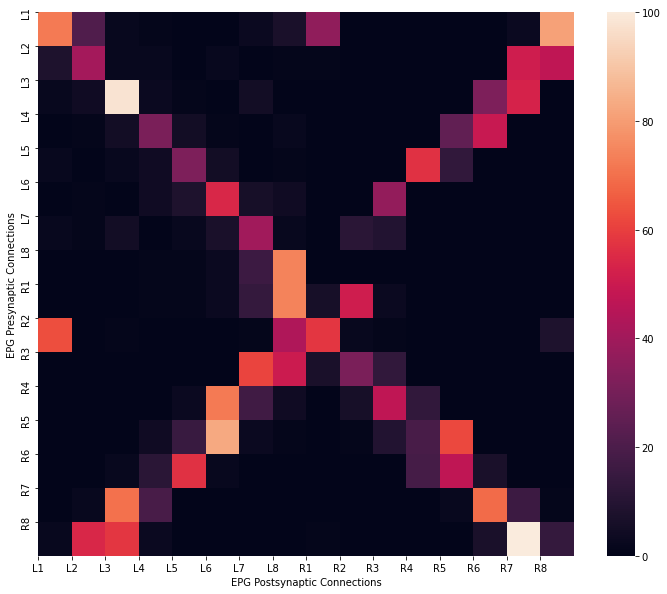

In [56]:
# Connectivity heatmap
import seaborn as sns

plt.figure(figsize = (12,10))
sns.heatmap(conn)
# plt.ylim([0, 10]);
EPGs = ['L1','L2','L3','L4','L5','L6','L7','L8','R1','R2','R3','R4','R5','R6','R7','R8']
plt.xticks(range(len(EPGs)), EPGs);
plt.yticks(range(len(EPGs)), EPGs);
plt.ylabel('EPG Presynaptic Connections');
plt.xlabel('EPG Postsynaptic Connections');